In [2]:
import sys
!{sys.executable} -m pip install colossus
!{sys.executable} -m pip install emcee
!{sys.executable} -m pip install corner

In [3]:
import numpy as np
import scipy
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from matplotlib import pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
import matplotlib as mpl
from scipy.optimize import curve_fit

import emcee
import corner

mpl.rcParams['agg.path.chunksize'] = 10000  # This is required to correctly plot the mass function evaluated on the data array



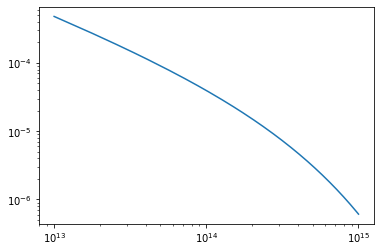

In [4]:

## cosmology.setCosmology('WMAP9') This is a default cosmology

params = {'flat': True, 'H0': 67.77, 'Om0': 0.31, 'Ob0': 0.048254, 'sigma8': 0.81, 'ns': 0.96} # This sets a customized cosmology
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')

# Array of masses
m_arr = np.linspace(1E13,1E15,128)

##for mass in m_arr:
mfunc_so = mass_function.massFunction(m_arr, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM') # q_out modifies the output function
##    mfunc_fof = mass_function.massFunction(mass, 0.0, mdef = 'fof', model = 'watson13', q_out = dndlnM))
plt.loglog(m_arr,  mfunc_so)


plt.show()   

In [5]:
a = np.load('converted_catalog_z0.000_mock0001.npz') # Import the catalog and read through it
print(a.files)
print(a['mass'].shape) # a['masss] is an array with 2772758 components
print(a['mass'].shape)
print(np.max(a['mass']))
print(len(a['mass']))
print(np.max(a['pos']))

print(np.log10(np.e))
BoxVolume = np.amax(a['pos'])**3.

print(BoxVolume)

['mass', 'pos']
(2772758,)
(2772758,)
5705458771838476.0
2772758
3869.9985
0.4342944819032518
57960537183.56983


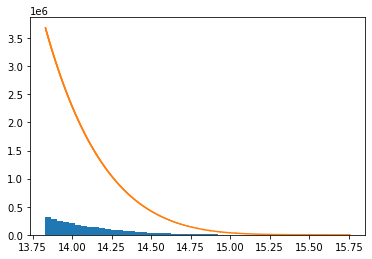

In [6]:
xmin = np.min(a['mass'])
xmax = np.max(a['mass'])
plt.hist(np.log10(a['mass']), bins=51, range = (np.log10(xmin), np.log10(xmax) ) )#Histogram of log-mass catalog, density=True gives a normalized histogram


m_arr = a['mass']
m_arr.sort() # order by increasing value
mfunc_so = mass_function.massFunction(m_arr, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')

plt.plot(np.log10(m_arr), BoxVolume*mfunc_so) 
plt.show()

[50.00001946  0.1         0.8       ]


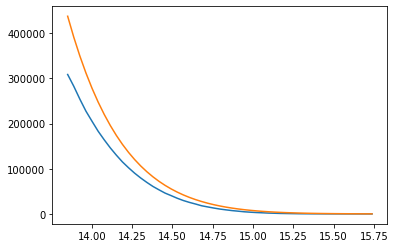

In [7]:
bin_heights, bin_borders = np.histogram(np.log10(a['mass']), bins=51, range = (np.log10(xmin), np.log10(xmax) ))
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2

# Let us perform a preliminary fit
def func(x, a1, a2, a3):
    params = {'flat': True, 'H0': a1, 'Om0': a2, 'Ob0': 0.049,'sigma8': a3, 'ns': 0.95} # This sets a customized cosmology
    cosmology.addCosmology('myCosmofit', params)
    cosmo = cosmology.setCosmology('myCosmofit')
    mfunc_so = BoxVolume*mass_function.massFunction(x, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
    return mfunc_so


xdata = 10**(bin_centers)
ydata = bin_heights

popt, pcov = curve_fit(func, xdata, ydata, p0=[67., 0.3, 0.8], bounds=([50., 0.1, 0.1],[75, 0.5, 1.])) # Input params and bounds

print(popt) # Plot of estimated parameters (Terrible!)

plt.plot(np.log10(xdata), ydata)
plt.plot(np.log10(xdata), func(xdata, popt[0],popt[1], popt[2])) # Improvement needed, something starnge is happening
plt.show()

In [23]:
# Let us write the Likelihood function

def massfunction(theta, mass):
    Om0, sigma8 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.048254,'sigma8': sigma8, 'ns': 0.96} # This sets a customized cosmology
    cosmo = cosmology.setCosmology('likeCosmo',params)
    mfunc_so = np.array(BoxVolume*mass_function.massFunction(mass, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM'))
    return mfunc_so

def log_prior(theta):
    Om0, sigma8 = theta
    if 0.1 < Om0 < 1.0 and 0.1 < sigma8 < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, mass, ydata):
    #err = DM_err What do I use as error array?
    mfunc_so = massfunction(theta, mass)
    logl = np.sum(ydata*np.log(mfunc_so)- mfunc_so)# - np.log(scipy.special.gamma(mfunc_so+1.)))
    return logl

def log_posterior(theta, mass, ydata):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    logl = log_likelihood(theta, mass, ydata)
    logpos = logl+lp
    return logpos


In [24]:
theta = [0.3,0.3]
print(log_likelihood(theta, xdata, ydata))
print(massfunction(theta, xdata))
 
      
theta = [0.1,0.3]
print(log_likelihood(theta, xdata, ydata))
print(massfunction(theta, xdata))

15786238.319300283
[7.30120526e+03 5.10647974e+03 3.52509527e+03 2.40014185e+03
 1.61063111e+03 1.06440077e+03 6.92149935e+02 4.42481243e+02
 2.77830100e+02 1.71166284e+02 1.03359252e+02 6.11056719e+01
 3.53258526e+01 1.99447069e+01 1.09823715e+01 5.88938376e+00
 3.07100241e+00 1.55458701e+00 7.62633817e-01 3.61888735e-01
 1.65779396e-01 7.31583375e-02 3.10309331e-02 1.26205318e-02
 4.90900699e-03 1.82117159e-03 6.42515092e-04 2.14901226e-04
 6.79160908e-05 2.02087841e-05 5.64013833e-06 1.47046439e-06
 3.56568991e-07 8.00446987e-08 1.65521122e-08 3.13605143e-09
 5.41292516e-10 8.45921837e-11 1.18908814e-11 1.49282985e-12
 1.66119224e-13 1.62517304e-14 1.38561519e-15 1.01989915e-16
 6.41569334e-18 3.41168357e-19 1.51579035e-20 5.55611152e-22
 1.65751583e-23 3.96583717e-25 7.49103305e-27]
343345.5493573562
[2.47941009e+01 1.69001953e+01 1.14139860e+01 7.63580115e+00
 5.05834401e+00 3.31710061e+00 2.15258628e+00 1.38186022e+00
 8.77230976e-01 5.50489760e-01 3.41352744e-01 2.09081425e-01
 

In [28]:
pos = [0.5,0.8] + 1e-2 * np.random.randn(16, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xdata, ydata))
sampler.run_mcmc(pos, 200, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [06:18<00:00,  1.89s/it]


State([[0.10007596 0.72921801]
 [0.36332029 0.44242287]
 [0.10002535 0.7281133 ]
 [0.10008497 0.72795767]
 [0.10381924 0.72221814]
 [0.10017772 0.72833838]
 [0.10000121 0.72942583]
 [0.10013502 0.72808104]
 [0.10000628 0.72888587]
 [0.10010794 0.72792598]
 [0.10379289 0.71841739]
 [0.10012511 0.72810533]
 [0.10008034 0.7283618 ]
 [0.10002706 0.72757456]
 [0.10007821 0.72914121]
 [0.43788223 0.41802859]], log_prob=[30067757.62136008 29143417.36709031 30067749.08856505 30067656.84494434
 30067039.39905023 30067572.64460887 30067876.85447477 30067608.6562333
 30067849.45632205 30067624.56174593 30066328.95190702 30067624.01050695
 30067707.79919127 30067661.24758017 30067753.13187802 28740627.8591907 ], blobs=None, random_state=('MT19937', array([3242604946, 2779123350, 1834905569, 2948536755, 3238668966,
       3466486611, 2913823779, 2498235201, 3515631189, 3575419247,
       2674255495, 3143696440, 1123305491, 2082917032, 2257695935,
       2696007607, 3309603383, 4270725835, 141489150

(200, 16, 2)


Text(0.5, 0, 'step number')

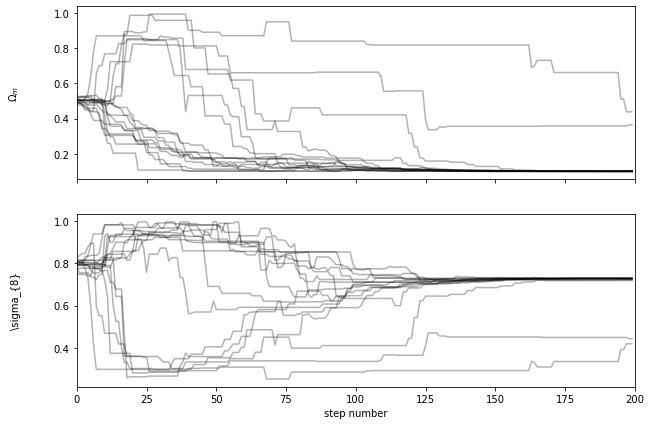

In [29]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
labels = ["$\Omega_{m}$", "\sigma_{8}"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

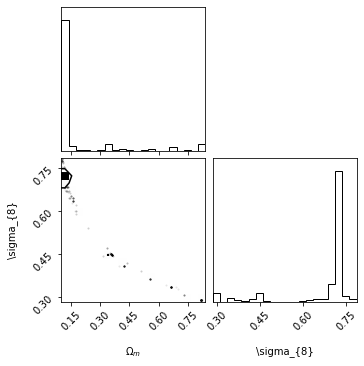

In [30]:
flat_samples = sampler.get_chain(discard=100, flat=True)

fig = corner.corner(flat_samples, labels=labels)